# Transfer learning with tf part 3: Scaling up
## Food Vision Mini

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

now we'll be working with all 101 classes of food

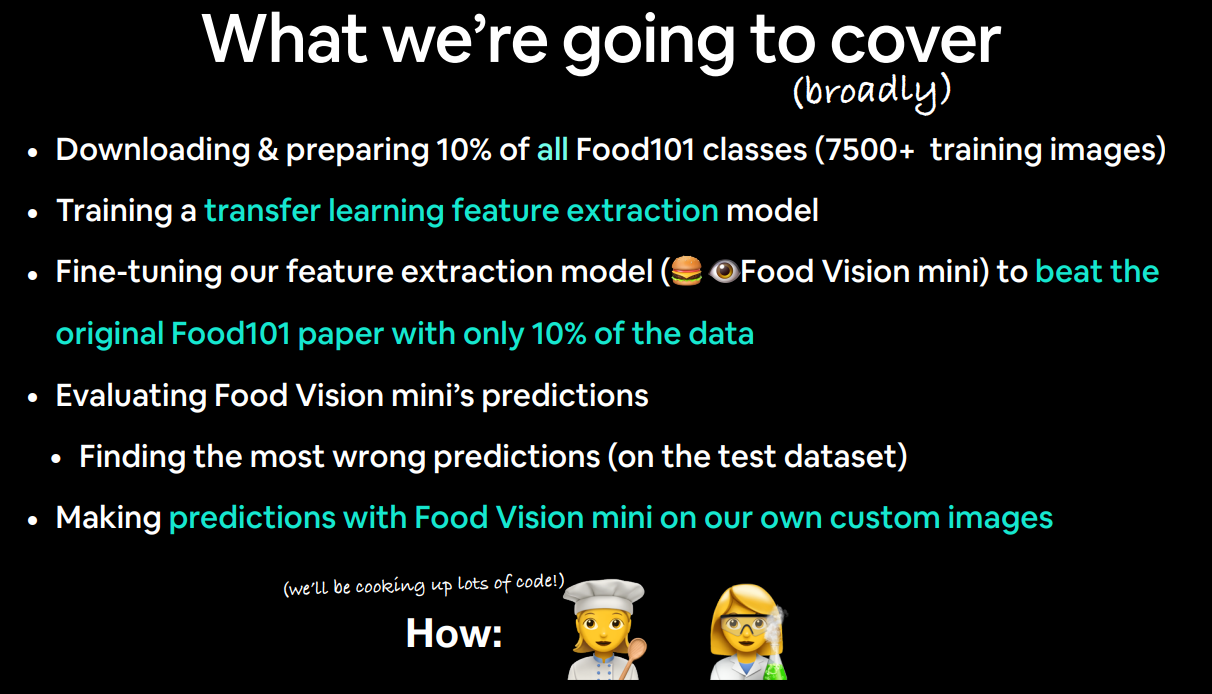

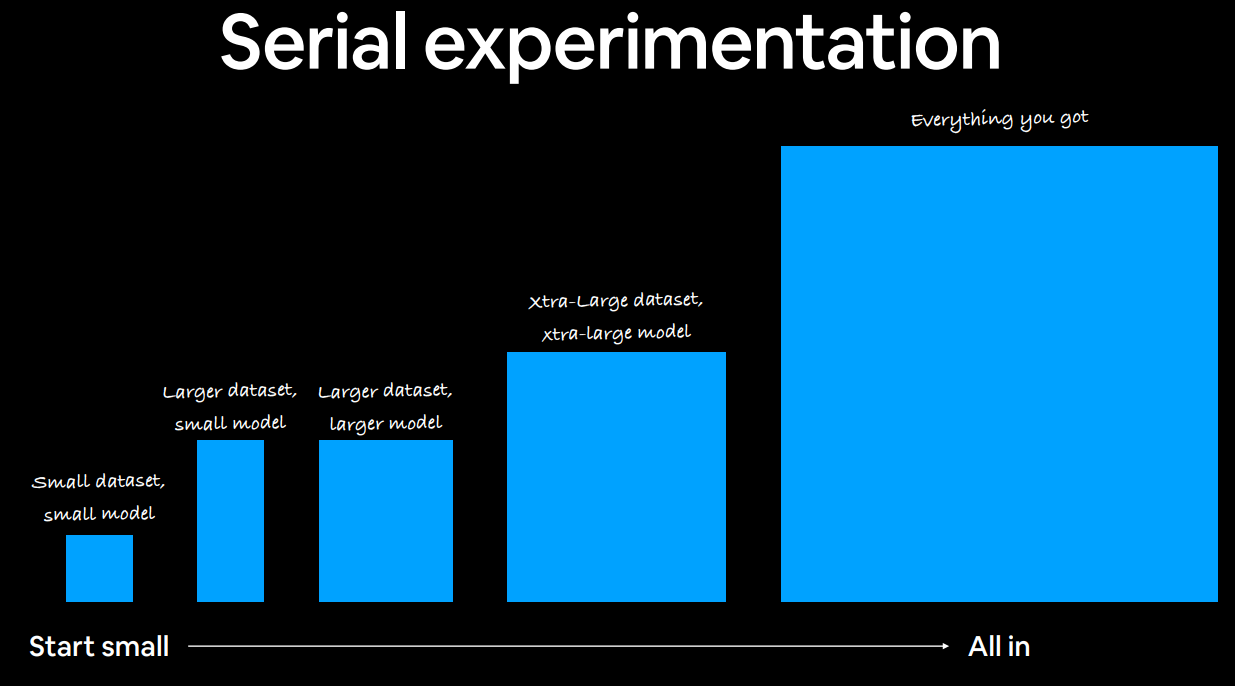

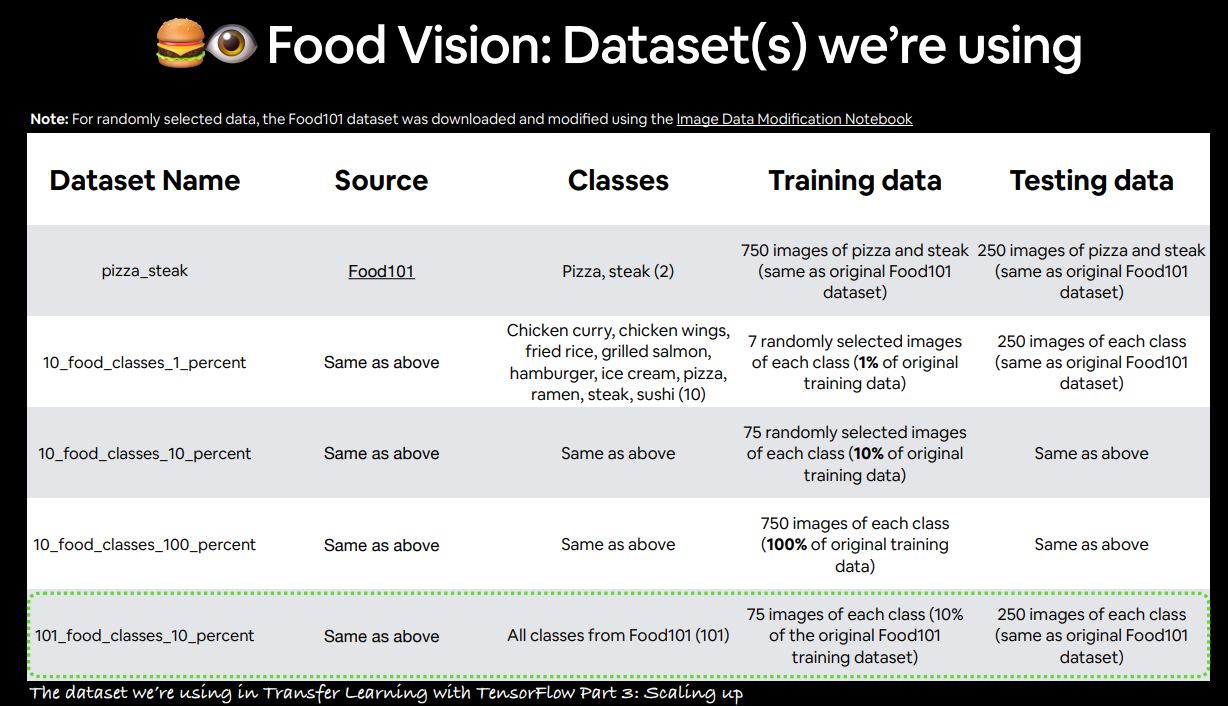

In [7]:
#insert helper functions that were created in previous videos
import helper_functions as hp
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

## 101 food classes: working with less data
our goal is to beat the original food101 paper with 10% of the training data

In [8]:
train_dir = 'datasets/101_food_classes_10_percent/train/'
test_dir = 'datasets/101_food_classes_10_percent/test/'

In [9]:
#check how many images/classes are there?
walk_through_dir('datasets/101_food_classes_10_percent/')

There are 2 directories and 0 images in 'datasets/101_food_classes_10_percent/'.
There are 101 directories and 0 images in 'datasets/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\apple_pie'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\baby_back_ribs'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\baklava'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beef_carpaccio'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beef_tartare'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beet_salad'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\beignets'.
There are 0 directories and 250 images in 'datasets/101_food_classes_10_percent/test\bibimbap'.
There are 0 directories and 250 images in 'dat

### set up data inputs

In [10]:
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = 'categorical',
                                                               image_size = IMG_SIZE,
                                                               shuffle = False) #dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with tl and 10% of 101 food classes

feature extraction transfer learning with a pre-trained efficientnet model and then we're going to fine tune it for a few more epochs

* set up a model checkpoint callback
* create a data augmentation layer to build data aug right into the model
* build a headless (no top layers) functional efficientnetb0 backboned model (we'll create our own output layer)
* compile our model
* feature extract for 5 epochs on the train dataset and validate on 15% of the test data to save epoch time)


In [12]:
# create checkpoint callback
checkpoint_path = '101_classes_10_percent_datda_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         monitor = 'val_accuracy', 
                                                         save_weights_only= True)

In [17]:
#create a data aug layer (when building this right into the model it has the benefit of running the aug
# right on the gpu)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [18]:
#set up data aug
data_aug = Sequential([preprocessing.RandomFlip('horizontal'),
                      preprocessing.RandomRotation(0.2),
                      preprocessing.RandomHeight(0.2),
                      preprocessing.RandomWidth(0.2),
                      preprocessing.RandomZoom(0.2)
                      # preprocessing.Rescaling(1/255.) rescale if not using efficientnet (since its built in)
                      ], name = 'data_aug')

In [20]:
#build headless (no top layer) functional effientnetb0 backboned model
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = 'input_layer')
x = data_aug(inputs) #augment images (only happens during training phase)
x = base_model(x, training = False) # this will put base model in inference mode so weights than need to stay frozen actually stay frozen)
x = layers.GlobalAveragePooling2D(name = 'gap')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

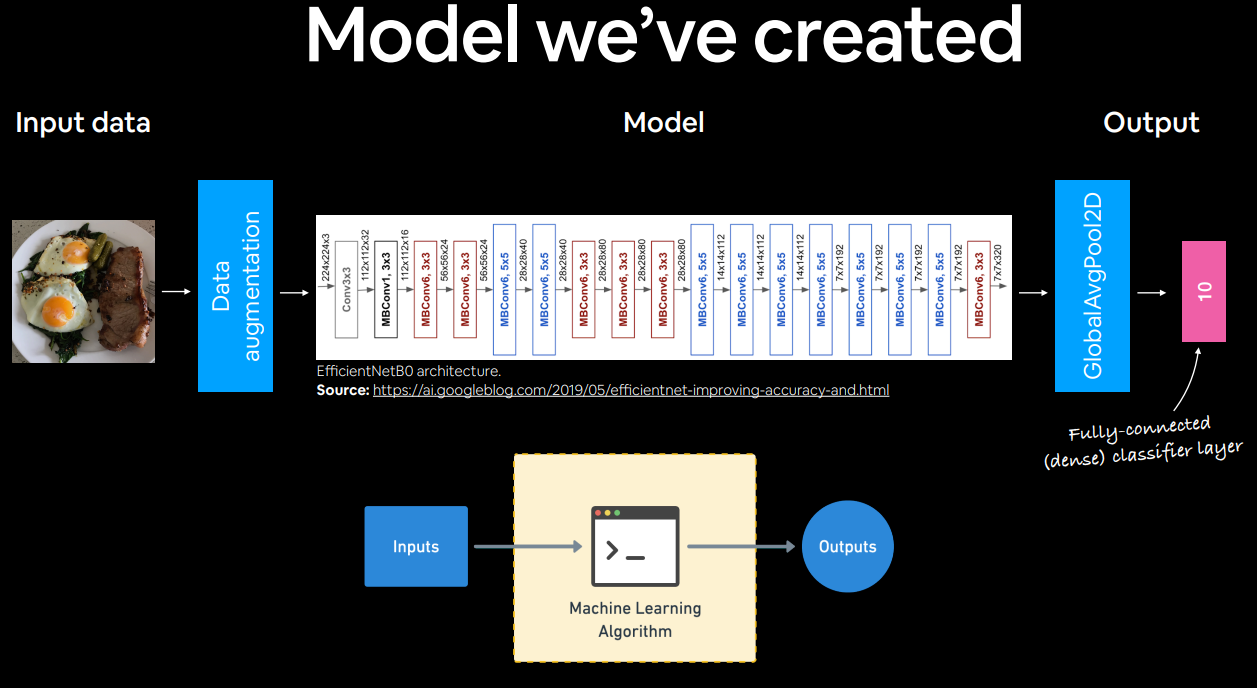

In [21]:
#get summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug (Sequential)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gap (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [22]:
#compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

#fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs = 5, #fit to 5 additional epochs
                                          validation_data = test_data,
                                          validation_steps = int(0.15 * len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 111s 376ms/step - loss: 3.3764 - accuracy: 0.2752 - val_loss: 2.5365 - val_accuracy: 0.4423
Epoch 2/5
237/237 [==============================] - 68s 286ms/step - loss: 2.1915 - accuracy: 0.4994 - val_loss: 2.0680 - val_accuracy: 0.4950
Epoch 3/5
237/237 [==============================] - 62s 260ms/step - loss: 1.8203 - accuracy: 0.5690 - val_loss: 1.9189 - val_accuracy: 0.5177
Epoch 4/5
237/237 [==============================] - 54s 229ms/step - loss: 1.5987 - accuracy: 0.6115 - val_loss: 1.8164 - val_accuracy: 0.5334
Epoch 5/5
237/237 [==============================] - 52s 218ms/step - loss: 1.4497 - accuracy: 0.6488 - val_loss: 1.8052 - val_accuracy: 0.5294


In [23]:
#evaluate on the whole test dataset

fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 61s 77ms/step - loss: 1.5796 - accuracy: 0.5844


[1.5796244144439697, 0.5844356417655945]

In [24]:
#we've beaten the baseline

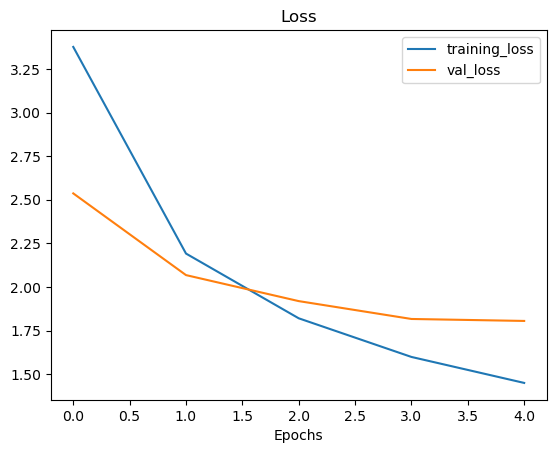

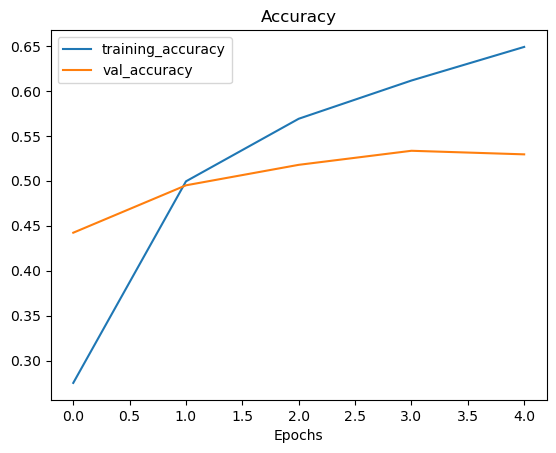

In [25]:
plot_loss_curves(history_all_classes_10_percent)
# curves show overfitting of the data
#i.e. its learning the training data but not the test data

### fine tuning

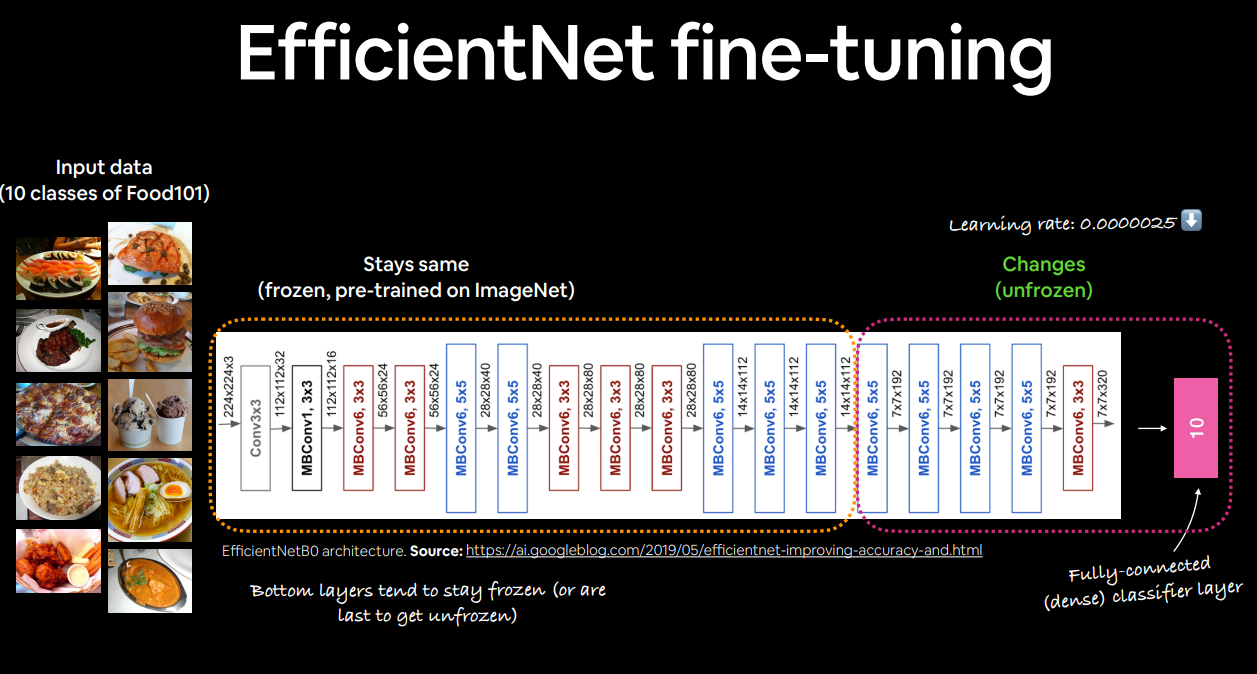

In [26]:
#unfreeze all layers in our base model to prepare for fine-tuning
base_model.trainable = True

#refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [28]:
#recompile model with lower learning rate (its best practice to lower lr by 10x)
#the more layers that are unfrozen the lower the learning rate needs to be
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

In [29]:
#what layers are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_aug True
efficientnetb0 True
gap True
output_layer True


In [30]:
#check which layers ar etrainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [32]:
#now we can fine tune the model starting off from 
#where we left off with our feature extraction model above

fine_tune_epochs = 10 #model has already done 5 epochs so now we want to do another 5

#fine tune the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                    epochs = fine_tune_epochs,
                                                    validation_data = test_data,
                                                    validation_steps = int(0.15 * len(test_data)),
                                                    initial_epoch = history_all_classes_10_percent.epoch[-1])  #         

Epoch 5/10
237/237 [==============================] - 60s 225ms/step - loss: 1.2141 - accuracy: 0.6851 - val_loss: 1.7520 - val_accuracy: 0.5403
Epoch 6/10
237/237 [==============================] - 50s 209ms/step - loss: 1.0936 - accuracy: 0.7089 - val_loss: 1.7514 - val_accuracy: 0.5456
Epoch 7/10
237/237 [==============================] - 47s 199ms/step - loss: 1.0014 - accuracy: 0.7314 - val_loss: 1.7413 - val_accuracy: 0.5495
Epoch 8/10
237/237 [==============================] - 46s 194ms/step - loss: 0.9462 - accuracy: 0.7417 - val_loss: 1.7456 - val_accuracy: 0.5453
Epoch 9/10
237/237 [==============================] - 44s 186ms/step - loss: 0.8889 - accuracy: 0.7633 - val_loss: 1.7158 - val_accuracy: 0.5490
Epoch 10/10
237/237 [==============================] - 41s 175ms/step - loss: 0.8247 - accuracy: 0.7762 - val_loss: 1.7504 - val_accuracy: 0.5389


In [34]:
#evaluate on the whole test data
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 57s 72ms/step - loss: 1.4965 - accuracy: 0.6040


[1.4964905977249146, 0.6040396094322205]

In [35]:
#we can see the accuracy increase by 2% or so when doing fine-tuning

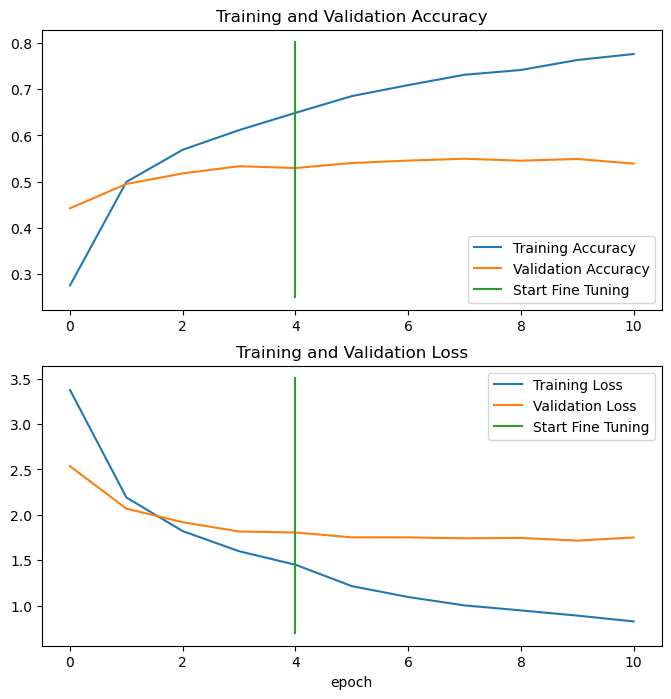

In [36]:
#compare the histories of feature extraction model with fine tuning model
compare_historys(original_history = history_all_classes_10_percent, 
                 new_history= history_all_classes_10_percent_fine_tune, 
                 initial_epochs = 5)

the seperation of the curves implies there is still overfitting going on.
how to prevent overfitting?


### saving and loading our trained model
to use our model in an external aplication we'll ned to save it and export it somewhere

In [37]:
model.save('101_food_classes_10_percent_model')

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_model\assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_model\assets


In [39]:
#load and evaluate saved model
loaded_model = tf.keras.models.load_model('101_food_classes_10_percent_model/')

In [40]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 62s 77ms/step - loss: 1.4965 - accuracy: 0.6040


[1.4964905977249146, 0.6040396094322205]

In [41]:
#saved model has same performance as the model before saving.

### evaluating performance model across all different classes
let's make some predictions, viz them, and then find out which predictions were the most wrong.

In [42]:
big_dog_model = tf.keras.models.load_model('datasets/06_101_food_class_10_percent_saved_big_dog_model/')
#can ignore the warning messages below

In [43]:
big_dog_model.evaluate(test_data)

790/790 [==============================] - 62s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]